In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
path = 'data/healthcare-dataset-stroke-data.csv'

dataframe = pd.read_csv(path)
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Some features contain missing values that need to be imputed or otherwise handled. Additionally, certain numerical features exhibit high cardinality, which may be better represented using binning or range-based grouping. Let's perform an exploratory analysis to determine the most suitable preprocessing strategies.

### Data Analyzing 

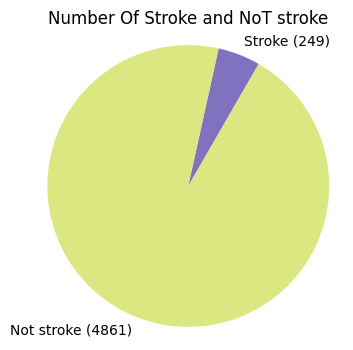

In [4]:
#lets anakyze the number of individuals with stroke and non-stroke
# Labels and percentages
labels_raw = ['Stroke', 'Not stroke']
sizes = [dataframe[dataframe['stroke']==1].shape[0], dataframe[dataframe['stroke']==0].shape[0]]

# Add counts to labels
labels = [f"{label} ({count})" for label, count in zip(labels_raw, sizes)]
colors = ["#8072be","#DBE781"]

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, colors=colors, startangle=60)
plt.title('Number Of Stroke and NoT stroke')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()


In [5]:
def is_not_float_or_nan(x):
    return pd.isna(x) or not isinstance(x,float)

In [6]:
#get the values that are not float type
bmi = dataframe[['bmi']]
mask = bmi.applymap(is_not_float_or_nan)
nan_count = mask.sum().item()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_79378/1820511369.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = bmi.applymap(is_not_float_or_nan)


In [7]:
total = len(dataframe)
not_nan_count = total - nan_count

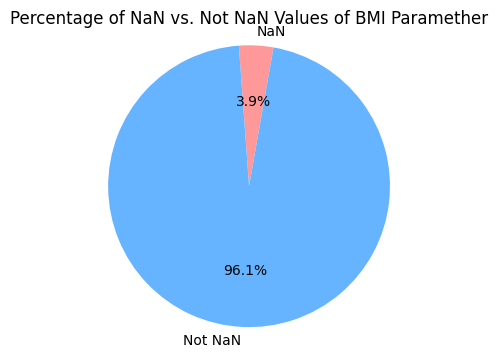

In [8]:
# Labels and percentages
labels = ['NaN', 'Not NaN']
sizes = [nan_count, not_nan_count]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80)
plt.title('Percentage of NaN vs. Not NaN Values of BMI Paramether')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()

As we see it's only 3.9% of the data that have missing values. So I use the techniques to fill that missing values and then apply bining to the some features of the data set, like age,bmi and average glucose level.

I binned the age feature into defined ranges and added a new column to display the age group for each entry in the dataset.

In [9]:
bins = [0, 2, 18, 40, 60, 82]
labels = ['newborn', 'child', 'young adult', 'middle age', 'senior']

dataframe['age_group'] = pd.cut(dataframe['age'],bins = bins,labels = labels,right=True)


In [10]:
dataframe

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,senior
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,senior
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,senior
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,middle age
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,senior
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,senior
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,young adult
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,middle age


By binning the age feature into defined groups, we can impute missing BMI values more effectively. The approach involves replacing a missing BMI with the average BMI of the corresponding age group. This method is likely to be more accurate than simply using the overall average BMI across the entire dataset.

For each group range calculate the bmi average value.

In [11]:
#fill the missing values in the bmi paramether using median of the each age group that was create previous
dataframe['bmi'] = dataframe.groupby('age_group')['bmi'].transform(lambda x: x.fillna(x.median()))


/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_79378/2275576599.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe['bmi'] = dataframe.groupby('age_group')['bmi'].transform(lambda x: x.fillna(x.median()))


In [12]:
dataframe

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,senior
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.1,never smoked,1,senior
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,senior
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,middle age
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0,senior
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,senior
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,young adult
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,middle age


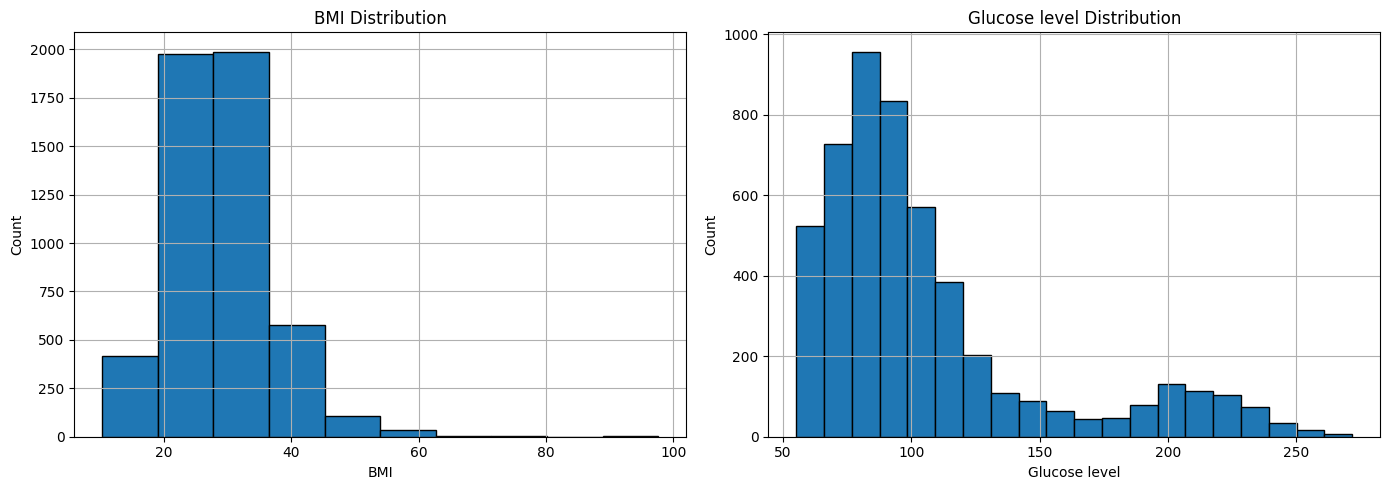

In [13]:
#plot the bmi that was before 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dataframe['bmi'], bins=10, edgecolor='black')
axes[0].set_title('BMI Distribution')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Count')
axes[0].grid(True)

axes[1].hist(dataframe['avg_glucose_level'], bins=20, edgecolor='black')
axes[1].set_title('Glucose level Distribution')
axes[1].set_xlabel('Glucose level')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Encode 'Sex' column
dataframe.loc[:, 'ever_married'] = dataframe['ever_married'].map({'No': 0, 'Yes': 1})

Let's analyze the connections between , age and stroke, average glucose level and stroke, bmi amd age 

In [15]:
# Group by age and stroke, then calculate the mean glucose
grouped = dataframe.groupby(['age', 'stroke'])['avg_glucose_level'].mean().unstack()

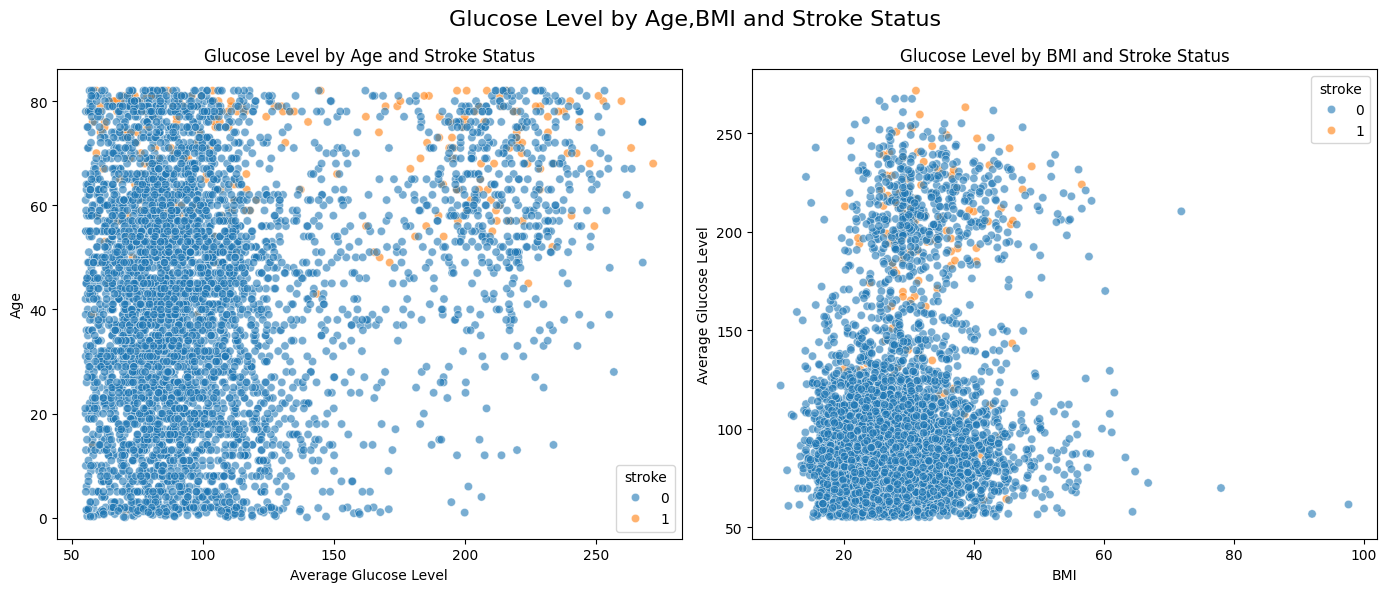

In [16]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data= dataframe, x='avg_glucose_level', y='age', hue='stroke', alpha=0.6,  ax=axes[0])

axes[0].set_title("Glucose Level by Age and Stroke Status")
axes[0].set_xlabel("Average Glucose Level")
axes[0].set_ylabel("Age")

sns.scatterplot(data= dataframe, y='avg_glucose_level', x='bmi', hue='stroke', alpha=0.6,  ax=axes[1])
axes[1].set_title("Glucose Level by BMI and Stroke Status")
axes[1].set_ylabel("Average Glucose Level")
axes[1].set_xlabel("BMI")

# Overall figure title
plt.suptitle('Glucose Level by Age,BMI and Stroke Status', fontsize=16)
plt.tight_layout()
plt.show()

Distribution of numerical attributes with stroke and each other.This plot present the distribution plots for age agains average glucose level, bmi against average glucose level based on stroke occurance.
We can observe a relationship between average glucose level and stroke risk at certain age ranges. Specifically, higher glucose levels in older individuals appear to be associated with a greater likelihood of stroke. In contrast, there is no clear correlation between average glucose level and BMI — the glucose levels vary widely across similar BMI values. Therefore, we can conclude that the connection between glucose levels and age in relation to stroke is stronger than the relationship between BMI, glucose, and stroke.

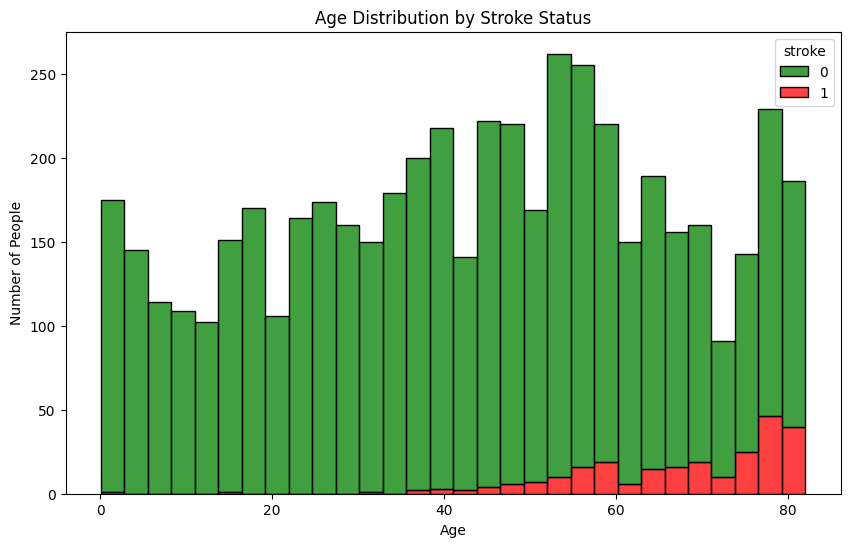

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(data=dataframe, x='age', hue='stroke', multiple='stack', bins=30, palette=['green', 'red'])
plt.title('Age Distribution by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.show()

### Lets see how the hypertension and heart desiases effects possibility of stroke.

In [18]:
hypertension_stroke = dataframe[(dataframe['hypertension'] == 1) & (dataframe['stroke'] == 1)].shape[0]
no_hypertension_stroke = dataframe[(dataframe['hypertension']==0) & (dataframe['stroke'] == 1)].shape[0]
hypertension_no_stroke = dataframe[(dataframe['hypertension'] == 1) & (dataframe['stroke'] == 0)].shape[0]

In [19]:
hypertension_stroke,no_hypertension_stroke,hypertension_no_stroke

(66, 183, 432)

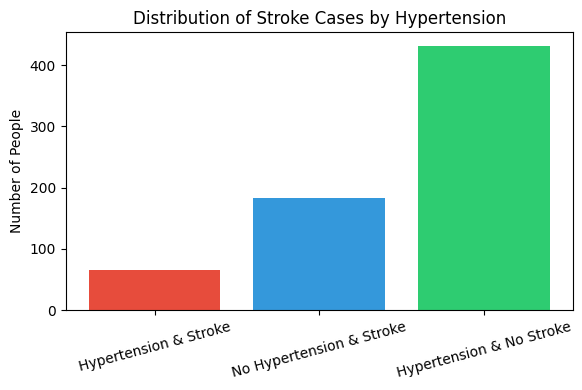

In [20]:
labels = ['Hypertension & Stroke', 'No Hypertension & Stroke', 'Hypertension & No Stroke']
counts = [
    hypertension_stroke,
    no_hypertension_stroke,
    hypertension_no_stroke
]


plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['#e74c3c', '#3498db', '#2ecc71'])
plt.title('Distribution of Stroke Cases by Hypertension')
plt.ylabel('Number of People')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

We can see that the number of cases where hypertension exists but no stroke occurred is significantly higher. However, it's important to note that the overall number of stroke cases is relatively low in the dataset, so direct comparison between stroke and non-stroke groups may be misleading.

Let's continue to analyze our dataset and find some correlation in it. Let's what the number of smokers and these that had heart desiases.


In [21]:
smoke_labels = dataframe['smoking_status'].unique()

In [22]:
#let's visualize data of smokers 
dict_smoke = {}
for label in smoke_labels:
    count = dataframe[dataframe['smoking_status'] == label].shape[0]
    dict_smoke[label] = count

In [23]:
dict_smoke

{'formerly smoked': 885, 'never smoked': 1892, 'smokes': 789, 'Unknown': 1544}

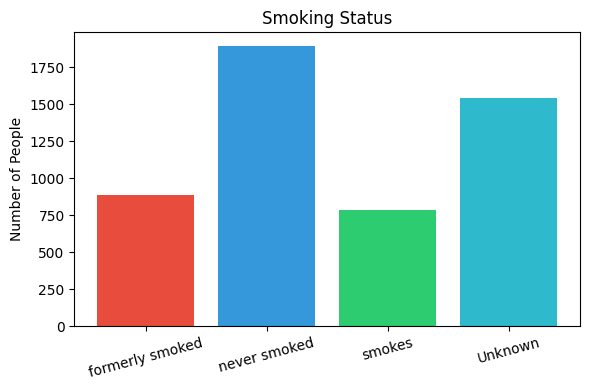

In [24]:
plt.figure(figsize=(6,4))
plt.bar(smoke_labels,dict_smoke.values(),color=['#e74c3c', '#3498db', '#2ecc71',"#2ebacc"])
plt.title('Smoking Status')
plt.ylabel('Number of People')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

From this plot, we can observe that a large portion of the data has an "unknown" smoking status. 

As a result, we can only analyze the correlation between stroke and known smoking statuses for about 3,500 individuals—which is not a very large sample.Therefore, I want to check how many people who had a stroke also have an "unknown" smoking status.    
Why is this important? Because stroke cases make up only about 5% of the dataset, and if a significant portion of those cases also fall under the "unknown" smoking category, it would limit our ability to draw meaningful conclusions about the correlation between smoking and stroke.

In [25]:
number_of_stroke_unknown = dataframe[(dataframe['smoking_status']=="Unknown") & (dataframe['stroke'] ==1)].shape[0]

print(f"Number of individuals with the stroke positive and uknowm smoking status is {number_of_stroke_unknown}")


Number of individuals with the stroke positive and uknowm smoking status is 47


So Number of individuals with the stroke positive and uknowm smoking status is only 19% from the number of stroke data. We still have the 200 samples of stroke and known smoking status to analyze.

In [26]:
#let's visualize data of smokers 
dict_smoke_and_stroke = {}
for label in smoke_labels:
    count = dataframe[(dataframe['smoking_status'] == label) & (dataframe['stroke']== 1)].shape[0]
    dict_smoke_and_stroke[f"{label} & stroke"] = count

In [27]:
dict_smoke_and_stroke

{'formerly smoked & stroke': 70,
 'never smoked & stroke': 90,
 'smokes & stroke': 42,
 'Unknown & stroke': 47}

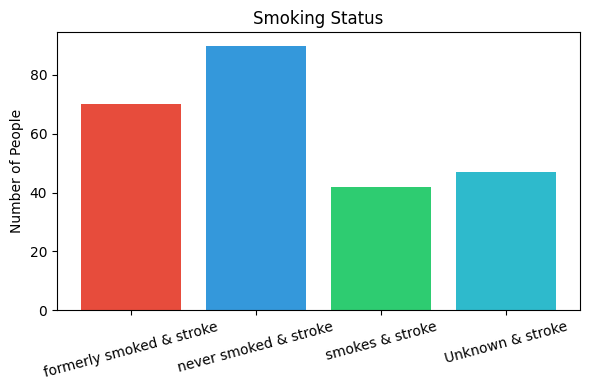

In [28]:
plt.figure(figsize=(6,4))
plt.bar(dict_smoke_and_stroke.keys(),dict_smoke_and_stroke.values(),color=['#e74c3c', '#3498db', '#2ecc71',"#2ebacc"])
plt.title('Smoking Status')
plt.ylabel('Number of People')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

We can conclude from the data that there are more stroke cases among people who formerly smoked or currently smoke compared to those who never smoked. However, the difference is not particularly large.

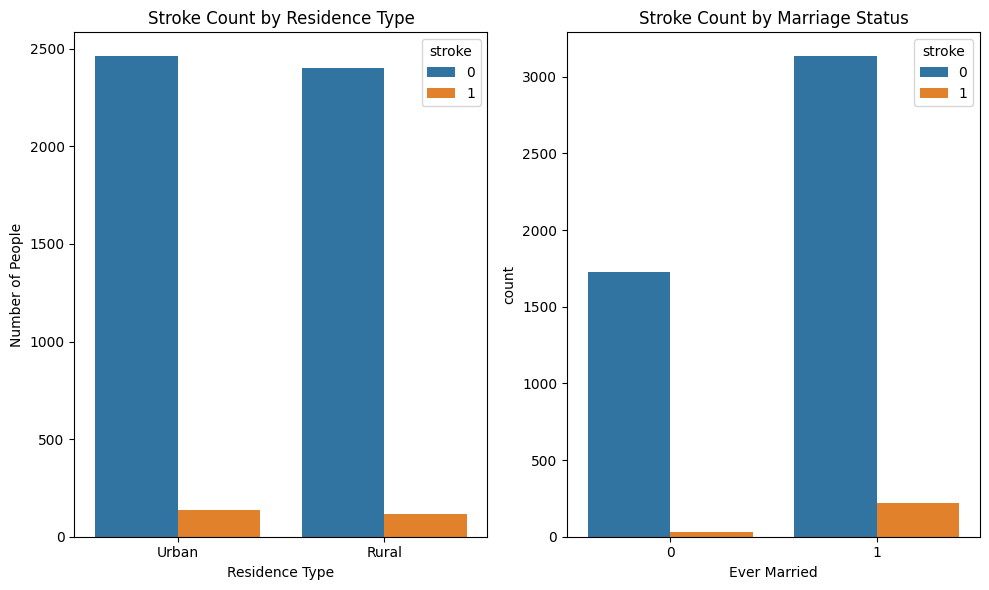

In [29]:
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.countplot(data=dataframe, x='Residence_type', hue='stroke',ax = axes[0])
axes[0].set_title('Stroke Count by Residence Type')

axes[0].set_xlabel('Residence Type')
axes[0].set_ylabel('Number of People')

sns.countplot(data=dataframe,x = 'ever_married',hue='stroke',ax=axes[1])
axes[1].set_title('Stroke Count by Marriage Status')
axes[1].set_xlabel('Ever Married')

plt.tight_layout()
plt.show()

We can see that there is no significant difference in the number of stroke-positive cases between individuals living in urban and rural areas.    
Another interesting observation is that stroke-positive cases appear to be more common among individuals who are married. While this does not imply a causal relationship, it may reflect underlying factors such as age, lifestyle, or health status, as married individuals tend to be older on average.

In this analysis, a significant challenge in understanding the connection between the parameters and stroke occurrence is the limited number of stroke-positive samples.